**Segmentez des clients d'un site e-commerce - Simulation de maintenance**

L’objectif de ce notebook est de réaliser une analyse de stabilité des segments dans le temps, afin de recommander une fréquence optimale de mise à jour du modèle de segmentation développé dans le notebook précédent.

Cette recommandation a pour but de :

- garantir la pertinence continue du modèle,

- aider à dimensionner un contrat de maintenance adapté.

# Importation des librairies

In [1]:
# === Manipulation et analyse de données ===
import pandas as pd
import numpy as np

# === Visualisation ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Statistiques et tests ===
from scipy import stats
from scipy.stats import ks_2samp

# === Machine Learning / Clustering ===
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# === Outils divers ===
import calendar  # Pour manipuler les mois, jours, etc.
import joblib    # Pour sauvegarder ou charger des modèles
import sqlite3   # Pour gérer des bases de données SQLite
from scipy.optimize import linear_sum_assignment  # Pour l’algorithme hongrois (appariement de clusters)
from sklearn.preprocessing import StandardScaler

# Importation des données

In [2]:
# Charger les fichiers Pickle
customers_cleaned = pd.read_pickle("customers_cleaned.pkl")
geoloc_cleaned = pd.read_pickle("geoloc_cleaned.pkl")
order_items_cleaned = pd.read_pickle("order_items_cleaned.pkl")
order_reviews_cleaned = pd.read_pickle("order_reviews_cleaned.pkl")
orders_cleaned = pd.read_pickle("orders_cleaned.pkl")
products_cleaned = pd.read_pickle("products_cleaned.pkl")
sellers_cleaned = pd.read_pickle("sellers_cleaned.pkl")
translation_cleaned = pd.read_pickle("translation_cleaned.pkl")
order_pymts = pd.read_pickle("order_pymts.pkl") 

# Vérifier les dimensions des DataFrames chargés
print(f"customers_cleaned: {customers_cleaned.shape}")
print(f"geoloc_cleaned: {geoloc_cleaned.shape}")
print(f"order_items_cleaned: {order_items_cleaned.shape}")
print(f"order_reviews_cleaned: {order_reviews_cleaned.shape}")
print(f"orders_cleaned: {orders_cleaned.shape}")
print(f"products_cleaned: {products_cleaned.shape}")
print(f"sellers_cleaned: {sellers_cleaned.shape}")
print(f"translation_cleaned: {translation_cleaned.shape}")
print(f"order_pymts: {order_pymts.shape}")

customers_cleaned: (99441, 6)
geoloc_cleaned: (1000163, 6)
order_items_cleaned: (112650, 8)
order_reviews_cleaned: (99224, 8)
orders_cleaned: (96478, 8)
products_cleaned: (32951, 10)
sellers_cleaned: (3095, 5)
translation_cleaned: (74, 4)
order_pymts: (103886, 6)


# Définition de la stratégie d'analyse temporelle

In [3]:
print(f"Date minimale : {orders_cleaned['date_achat'].min()}")
print(f"Date maximale : {orders_cleaned['date_achat'].max()}")

Date minimale : 2016-09-15 12:16:38
Date maximale : 2018-08-29 15:00:37


Pour déterminer la fréquence optimale de mise à jour du modèle de segmentation, nous avons adopté une approche comparative mensuelle structurée et adaptée à la réalité de notre clientèle, caractérisée par un fort renouvellement.

**Modèle de référence (KMeans0)**<br>
Un modèle K-Means est entraîné sur les données de janvier 2017, qui constitue notre base de référence.

**Analyse mensuelle**
- Pour chaque mois suivant (février 2017, mars 2017, etc.), un nouveau modèle K-Means est entraîné sur les données du mois courant.
- En parallèle, le modèle de référence (KMeans0) est utilisé pour prédire les clusters sur les données de chaque nouveau mois.

**Comparaison des segmentations**
- Pour chaque mois, nous comparons la segmentation obtenue par le modèle réentraîné (KMeans_n) à celle prédite par le modèle initial (KMeans0).
- Cette comparaison s’effectue à l’aide de l’Adjusted Rand Index (ARI), qui mesure la similarité entre deux segmentations indépendamment de l’ordre des clusters.

**Objectif de l’approche**
- Quantifier la stabilité temporelle des clusters :
En suivant l’évolution de l’ARI mois après mois, nous pouvons détecter à quel moment la segmentation issue du modèle initial ne correspond plus à la réalité des données.

- Déterminer un seuil de réentraînement :
Un seuil d’ARI (par exemple 0,8) permet de fixer objectivement le moment où il devient nécessaire de réentraîner le modèle pour garantir la pertinence de la segmentation.

**Pourquoi cette méthode ?**
- Population très mouvante :
La majorité de nos clients ne commandant qu’une seule fois, la composition de la clientèle change fortement chaque mois.
Cumuler les données sur plusieurs mois diluerait les comportements récents et masquerait les évolutions réelles.

- Réactivité :
L’analyse mensuelle permet de détecter immédiatement les changements et d’ajuster la segmentation en temps réel.

**Avantages**
- Permet de suivre précisément la dérive des clusters dans le temps, en tenant compte des évolutions réelles du comportement client.

- Fournit une base objective et mesurable pour recommander la fréquence de mise à jour du modèle dans le cadre d’un contrat de maintenance.

**Résumé**<br>
Cette stratégie comparative mensuelle, basée sur l’ARI entre le modèle initial et les modèles mensuels, permet de piloter la maintenance du modèle de segmentation de façon fiable, réactive et adaptée à la dynamique de notre clientèle.

# Construction des DataFrames pour l'analyse temporelle
## Préparation des données de commande
Dans cette étape, nous allons créer une fonction appelée preparer_donnees_commandes qui joue un rôle clé dans la préparation des données nécessaires à l'analyse. Cette fonction permet de fusionner et d'agréger les informations provenant de plusieurs tables, notamment les produits, les traductions des catégories de produits et les articles de commande.

L'objectif principal est de transformer ces données brutes en un DataFrame agrégé au niveau des commandes, contenant des métriques essentielles telles que :
- Le montant total par commande.
- Le nombre d'articles commandés.
- Les frais de livraison totaux.
- Les caractéristiques des produits (poids total, longueur moyenne des descriptions, etc.).
- La catégorie de produit la plus fréquente dans chaque commande.

Cette étape est cruciale pour structurer les données avant de les enrichir avec d'autres sources (paiements, avis clients, géolocalisation) dans les étapes suivantes.

In [4]:
def preparer_donnees_commandes(
    products_df,
    translation_df,
    order_items_df,
    cols_a_supprimer=['index', 'product_category_name']
):
    """
    Prépare les données des commandes en fusionnant les tables produits, traductions et order_items,
    puis effectue les agrégations nécessaires.

    Paramètres :
    ------------
    products_df : DataFrame
        DataFrame des produits (doit contenir 'product_category_name' et 'product_id')
    translation_df : DataFrame
        DataFrame des traductions (doit contenir 'product_category_name' et 'categorie_produit')
    order_items_df : DataFrame
        DataFrame des items de commande
    cols_a_supprimer : list, optional (default=['index', 'product_category_name'])
        Colonnes à supprimer après les fusions

    Retour :
    --------
    DataFrame agrégé avec les caractéristiques des commandes
    """
    
    # Étape 1: Fusion des produits avec les traductions
    df_products_translation = pd.merge(
        products_df,
        translation_df[['product_category_name', 'categorie_produit']],
        on='product_category_name',
        how='left'
    ).drop(columns=cols_a_supprimer, errors='ignore')

    # Étape 2: Fusion avec les items de commande
    df_orders_items_products = pd.merge(
        order_items_df,
        df_products_translation,
        on='product_id',
        how='left'
    ).drop(columns=cols_a_supprimer, errors='ignore')

    # Étape 3: Agrégation des commandes
    df_commandes_agg = df_orders_items_products.groupby("order_id").agg(
        montant_total=("price", "sum"),
        nombre_articles=("order_item_id", "count"),
        frais_livraison_total=("freight_value", "sum"),
        poids_total=("product_weight_g", "sum"),
        longueur_desc_totale=("product_description_lenght", "sum"),
        longueur_desc_moyenne=("product_description_lenght", "mean"),
        categorie_mode=("categorie_produit", lambda x: x.mode()[0])
    ).reset_index()

    # Étape 4: Calcul du montant moyen par article
    df_commandes_agg["montant_moyen_par_article"] = (
        df_commandes_agg["montant_total"] / df_commandes_agg["nombre_articles"]
    )

    return df_commandes_agg

In [5]:
# Appel de la fonction avec vos DataFrames
df_commandes_agg = preparer_donnees_commandes(
    products_cleaned,
    translation_cleaned,
    order_items_cleaned
)

In [6]:
df_commandes_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98666 entries, 0 to 98665
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   order_id                   98666 non-null  object 
 1   montant_total              98666 non-null  float64
 2   nombre_articles            98666 non-null  int64  
 3   frais_livraison_total      98666 non-null  float64
 4   poids_total                98666 non-null  float64
 5   longueur_desc_totale       98666 non-null  float64
 6   longueur_desc_moyenne      98666 non-null  float64
 7   categorie_mode             98666 non-null  object 
 8   montant_moyen_par_article  98666 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 6.8+ MB


In [7]:
df_commandes_agg['order_id'].nunique()

98666

## Préparation des données clients

Dans cette section, nous allons créer une fonction qui a pour objectif de combiner et d'enrichir les données clients à partir de plusieurs sources. Cette étape est essentielle pour construire un DataFrame final consolidé, contenant toutes les informations nécessaires pour l'analyse des comportements clients.

La fonction prend en entrée plusieurs DataFrames intermédiaires, notamment :
- Les commandes agrégées (issues de la fonction précédente).
- Les données des commandes nettoyées.
- Les paiements associés aux commandes.
- Les avis laissés par les clients.
- Les informations de géolocalisation.
- Les données des clients.

Elle effectue ensuite une série de transformations et de fusions pour enrichir les données et calculer des métriques clés, telles que :

- Délai de livraison : Temps écoulé entre l'achat et la livraison réelle.
- Retard de livraison : Différence entre la date estimée et la date réelle de livraison.
- Montant total payé : Somme des paiements effectués pour chaque commande.
- Moyens de paiement principaux : Type de paiement le plus utilisé par commande.
- Scores d'avis moyens : Moyenne des notes attribuées par les clients.
- Coordonnées géographiques : Latitude et longitude associées au code postal du client.

Cette fonction permet également de filtrer les données sur une plage temporelle définie grâce aux paramètres start_date et end_date. Cela nous permettra, dans les étapes suivantes, de créer un DataFrame spécifique pour chaque mois que nou étudierons.

In [8]:
def preparer_donnees_clients(
    df_commandes_agg,
    orders_cleaned,
    order_pymts,
    order_reviews_cleaned,
    geoloc_cleaned,
    customers_cleaned,
    start_date='2017-01-01',
    end_date=None
):
    """
    Prépare les données clients en fusionnant les commandes, paiements, avis et géolocalisation,
    calcule les colonnes nécessaires, puis effectue les agrégations pour obtenir un
    DataFrame final au niveau client avec 33 colonnes.

    Paramètres :
    ------------
    df_commandes_agg : DataFrame
        DataFrame agrégé des commandes.
    orders_cleaned : DataFrame
        Données des commandes nettoyées.
    order_pymts : DataFrame
        Données des paiements.
    order_reviews_cleaned : DataFrame
        Données des avis clients.
    geoloc_cleaned : DataFrame
        Données de géolocalisation.
    customers_cleaned : DataFrame
        Données des clients nettoyées.
    start_date : str
        Date de début pour filtrer les commandes (format 'YYYY-MM-DD').
    end_date : str or None
        Date de fin pour filtrer les commandes (format 'YYYY-MM-DD').

    Retour :
    --------
    DataFrame final contenant toutes les informations clients avec 33 colonnes.
    """
    
    # Étape 1 : Filtrer les données sur la plage temporelle
    orders_filtered = orders_cleaned[
        (orders_cleaned['date_achat'] >= pd.to_datetime(start_date))
        & (orders_cleaned['date_achat'] <= pd.to_datetime(end_date) if end_date else True)
    ]
    
    # Étape 2 : Fusion avec la table orders
    df_client_orders_full = pd.merge(
        df_commandes_agg,
        orders_filtered,
        on='order_id',
        how='inner'
    )
    df_client_orders_full.drop(columns=['index'], inplace=True)
    
    # Étape 3 : Création des nouvelles variables liées à la livraison
    df_client_orders_full["délai_livraison"] = (
        df_client_orders_full["date_livraison_reelle"] - df_client_orders_full["date_achat"]
    ).dt.days

    df_client_orders_full["retard_livraison"] = (
        df_client_orders_full["date_livraison_reelle"] - df_client_orders_full["date_livraison_estimee"]
    ).dt.days

    # Suppression des colonnes inutiles
    df_client_orders_full.drop(columns=['date_livraison_estimee', 'date_livraison_reelle',
                                        'date_approbation', 'date_expedition_transporteur'], inplace=True)
    
    # Étape 4 : Agrégation de order_payments au niveau de chaque commande
    order_payments_aggregated = order_pymts.groupby('order_id').agg(
        montant_total_paye=('payment_value', 'sum'), # Somme des montants payés
        nombre_paiements=('payment_sequential', 'max'), # Nb de paiements effectués pour la commande (max payment_sequential)
        nombre_echeances_moy=('payment_installments', 'mean'), # Nombre moyen d'échéances pour la commande
        diversite_moyens_paiement=('payment_type', 'nunique'), # Nombre de moyens de paiement distincts
        moyen_paiement_principal=('payment_type', lambda x: x.mode()[0]) # Moyen de paiement le plus utilisé
    ).reset_index()
    
    # Étape 5 : Fusion de df_client_orders_full avec order_payments_aggregated
    df_client_orders = pd.merge(
        df_client_orders_full, # DataFrame principal (détails des commandes)
        order_payments_aggregated, # DataFrame agrégé des paiements
        on='order_id', # Clé de jointure
        how='inner' # Garder toutes les lignes présentes dans les 2 tables
    )
    
    # Étape 6 : Agrégation des données d'avis par commande
    order_reviews_aggregated = order_reviews_cleaned.groupby('order_id').agg(
        note_moyenne=('review_score', 'mean'), # Note moyenne attribuée
        nombre_avis=('review_id', 'count') # Nombre total d'avis
    ).reset_index()
    
    # Étape 7 : Fusion des DataFrames df_client_orders et order_reviews_aggregated
    df_with_reviews = pd.merge(
        df_client_orders,
        order_reviews_aggregated,
        how='left',
        on='order_id')
    
    # Étape 8 : Regrouper par code postal et calculer la moyenne des latitudes et longitudes
    geoloc_agg = geoloc_cleaned.groupby('code_postal_geolocalisation', as_index=False).agg({
        'geolocation_lat': 'mean',
        'geolocation_lng': 'mean'
    })
    
    # Étape 9 : Fusionner customers_cleaned avec geoloc_agg sur le code postal
    customers_geo = customers_cleaned.merge(
        geoloc_agg,
        how='left',
        left_on='customer_code_postal',
        right_on='code_postal_geolocalisation'
    )

    # Supprimer la colonne redondante après la fusion
    customers_geo = customers_geo.drop(columns=['code_postal_geolocalisation'])
    
    # Étape 10 : Supprimer les lignes avec des valeurs manquantes dans la colonne geolocation_lat
    customers_geo = customers_geo.dropna(subset=['geolocation_lat'], inplace=False)
    
    # Étape 11 : Fusionner df_with_reviews avec customers_geo en utilisant une jointure interne
    df_final = df_with_reviews.merge(
        customers_geo,
        how='inner', # Jointure interne pour ne conserver que les commandes livrées
        on='customer_id'
    )

    # Étape 12 : Suppression de la colonne 'index'
    df_final.drop(columns=['index'], inplace=True)
    
     # Étape 13 : Trouver la date de la dernière commande dans le dataset filtré
    date_max = orders_filtered['date_achat'].max() 
    
    # Étape 14 : Convertir date_max en datetime
    date_max = pd.to_datetime(date_max)

    # Étape 15 : Ajouter la colonne saison en fonction du mois d'achat
    df_final['saison'] = df_final['date_achat'].dt.month.map({
        12: 'Hiver', 1: 'Hiver', 2: 'Hiver',
        3: 'Printemps', 4: 'Printemps', 5: 'Printemps',
        6: 'Été', 7: 'Été', 8: 'Été',
        9: 'Automne', 10: 'Automne', 11: 'Automne'
    })

    # Étape 16 : Ajouter la colonne jour en fonction du jour de la semaine
    df_final['jour'] = df_final['date_achat'].dt.day_name()

    # Étape 17 : Calculer le nombre de jours écoulés depuis l'achat
    df_final['jours_depuis_achat'] = (date_max - df_final['date_achat']).dt.days

    # Étape 18 : Agrégation par customer_unique_id
    df_aggregated = df_final.groupby('customer_unique_id').agg({
        'order_id': 'count', # Nombre total de commandes
        'montant_total': ['sum', 'mean'], # Montant total et moyen dépensé
        'nombre_articles': ['sum', 'mean'], # Nombre total et moyen d'articles
        'frais_livraison_total': ['sum', 'mean'], # Frais totaux et moyens
        'poids_total': ['sum', 'mean'], # Poids total et moyen des commandes
        'longueur_desc_totale': 'sum', # Longueur totale des descriptions
        'longueur_desc_moyenne': 'mean', # Moyenne des longueurs de description
        'categorie_mode': ['nunique', lambda x: x.mode()[0]], # Diversité et catégorie la plus fréquente
        'montant_moyen_par_article': 'mean', # Montant moyen par article
        'délai_livraison': 'mean', # Moyenne du délai de livraison
        'retard_livraison': ['mean', 'sum'], # Proportion et total des retards
        'montant_total_paye': 'sum', # Montant total payé
        'nombre_paiements': 'sum', # Nombre total de paiements
        'nombre_echeances_moy': 'mean', # Moyenne des échéances par commande
        'diversite_moyens_paiement': 'max', # Diversité maximale des moyens de paiement
        'moyen_paiement_principal': lambda x: x.mode()[0], # Moyen de paiement le plus utilisé
        'note_moyenne': 'mean', # Moyenne des notes données par le client
        'nombre_avis': 'sum', # Nombre total d'avis donnés par le client
        'saison': lambda x: x.mode()[0], # Saison la plus fréquente d'achat
        'jour': lambda x: x.mode()[0], # Jour le plus fréquent d'achat
        'jours_depuis_achat': 'min', # Récence maximale (dernier achat)
        'customer_city': lambda x: x.mode()[0], # Ville la plus fréquente du client
        'customer_state': lambda x: x.mode()[0], # État le plus fréquent du client
        'geolocation_lat': lambda x: x.mode()[0], # Latitude la plus fréquente du client
        'geolocation_lng': lambda x: x.mode()[0], # Longitude la plus fréquente du client
        'customer_code_postal': lambda x: x.mode()[0] # Code postal le plus fréquent du client
    }).reset_index()

    # Étape 19 : Aplatir les colonnes MultiIndex
    df_aggregated.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in df_aggregated.columns]

    # Étape 20 : Dictionnaire de mappage pour renommer les colonnes
    rename_dict = {
        'order_id_count': 'nb_commandes',
        'montant_total_sum': 'total_depense',
        'montant_total_mean': 'depense_moyenne_par_commande',
        'nombre_articles_sum': 'total_articles_achetes',
        'nombre_articles_mean': 'articles_moyens_par_commande',
        'frais_livraison_total_sum': 'total_frais_livraison',
        'frais_livraison_total_mean': 'frais_livraison_moyens',
        'poids_total_sum': 'poids_total_commandes',
        'poids_total_mean': 'poids_moyen_commandes',
        'longueur_desc_totale_sum': 'longueur_totale_descriptions',
        'longueur_desc_moyenne_mean': 'longueur_moyenne_descriptions',
        'categorie_mode_nunique': 'diversite_categories',
        'categorie_mode_<lambda_0>': 'categorie_la_plus_commandee',
        'montant_moyen_par_article_mean': 'depense_moyenne_par_article',
        'délai_livraison_mean': 'delai_livraison_moyen',
        'retard_livraison_mean': 'moy_retards_livraison',
        'retard_livraison_sum': 'total_retards_livraison',
        'montant_total_paye_sum': 'montant_total_paye',
        'nombre_paiements_sum': 'nb_paiements_total',
        'nombre_echeances_moy_mean': 'moyenne_echeances_paiement',
        'diversite_moyens_paiement_max': 'diversite_max_paiements',
        'moyen_paiement_principal_<lambda>': 'paiement_principal_utilise',
        'note_moyenne_mean': 'note_moyenne_client',
        'nombre_avis_sum': 'total_avis_donnes',
        'saison_<lambda>': 'saison_la_plus_frequente',
        'jour_<lambda>': 'jour_le_plus_frequent',
        'jours_depuis_achat_min': 'recence_en_jours',
        'customer_city_<lambda>': 'ville_principale_client',
        'customer_state_<lambda>': 'etat_principal_client',
        'geolocation_lat_<lambda>': 'latitude_principale_client',
        'geolocation_lng_<lambda>': 'longitude_principale_client',
        'customer_code_postal_<lambda>': 'code_postal_principal_client'
    }

    # Étape 21 : Renommer les colonnes
    df_aggregated.rename(columns=rename_dict, inplace=True)

    return df_aggregated

## Création des DataFrames temporels

Dans cette section, nous allons construire une série de DataFrames mensuels, chacun correspondant à un mois distinct de l’année 2017.<br>
L’objectif est d’analyser l’évolution des comportements clients et la stabilité des clusters mois par mois, conformément à la méthodologie de suivi recommandée.

Objectifs de cette approche<br>
Analyser la segmentation de façon granulaire : chaque DataFrame représente les clients actifs sur un mois donné.

Comparer la stabilité des clusters dans le temps : en appliquant le modèle initial sur chaque mois et en le comparant à un modèle réentraîné sur le même mois, on mesure la dérive des segments.

Déterminer précisément quand réentraîner le modèle : l’évolution des clusters est suivie mois par mois, ce qui permet d’identifier rapidement toute rupture ou changement de comportement.

Fonctionnement<br>
Création des DataFrames mensuels :<br>
À l’aide de la fonction preparer_donnees_clients, nous générons un DataFrame pour chaque mois de 2017, en filtrant les données selon la période souhaitée (ex : janvier 2017, février 2017, …, décembre 2017).

Organisation des DataFrames :<br>
Les DataFrames mensuels sont stockés dans une liste ou un dictionnaire, chaque élément correspondant à un mois distinct.

Analyse séquentielle :<br>
Cette structure permet de traiter chaque mois indépendamment, d’appliquer les modèles de segmentation, et de comparer les résultats pour évaluer la stabilité temporelle.

In [9]:
# Liste des mois à analyser
mois = [
    "2017-01", "2017-02", "2017-03", "2017-04", "2017-05", "2017-06",
    "2017-07", "2017-08", "2017-09", "2017-10", "2017-11", "2017-12"
]

# Dictionnaire pour stocker les DataFrames mensuels
dfs_mensuels = {}

# Boucle pour créer un DataFrame pour chaque mois
for m in mois:
    start_date = f"{m}-01" # Premier jour du mois
    end_date = pd.to_datetime(start_date) + pd.offsets.MonthEnd(0) # Dernier jour du mois
    end_date = end_date.strftime("%Y-%m-%d")

    # Générer le DataFrame pour le mois courant
    dfs_mensuels[m] = preparer_donnees_clients(
        df_commandes_agg=df_commandes_agg,
        orders_cleaned=orders_cleaned,
        order_pymts=order_pymts,
        order_reviews_cleaned=order_reviews_cleaned,
        geoloc_cleaned=geoloc_cleaned,
        customers_cleaned=customers_cleaned,
        start_date=start_date,
        end_date=end_date
    )
    print(f"DataFrame créé pour {m} ({len(dfs_mensuels[m])} clients)")

DataFrame créé pour 2017-01 (657 clients)
DataFrame créé pour 2017-02 (1577 clients)
DataFrame créé pour 2017-03 (2433 clients)
DataFrame créé pour 2017-04 (2202 clients)
DataFrame créé pour 2017-05 (3353 clients)
DataFrame créé pour 2017-06 (2971 clients)
DataFrame créé pour 2017-07 (3657 clients)
DataFrame créé pour 2017-08 (3963 clients)
DataFrame créé pour 2017-09 (3966 clients)
DataFrame créé pour 2017-10 (4251 clients)
DataFrame créé pour 2017-11 (6908 clients)
DataFrame créé pour 2017-12 (5364 clients)


## Traitement des notes moyennes des clients

Dans cette section, nous effectuons un traitement spécifique sur les notes moyennes attribuées par les clients. L'objectif est de :
- Créer une colonne binaire indiquant si un client a donné une note ou non.
- Remplacer les valeurs manquantes dans la colonne note_moyenne_client par la moyenne arrondie des notes existantes.

In [10]:
for m in mois:
    print(f"Colonnes avec valeurs manquantes pour {m} :")
    print(dfs_mensuels[m].isnull().sum()[dfs_mensuels[m].isnull().sum() > 0])
    print("-" * 40)

Colonnes avec valeurs manquantes pour 2017-01 :
note_moyenne_client    7
dtype: int64
----------------------------------------
Colonnes avec valeurs manquantes pour 2017-02 :
note_moyenne_client    10
dtype: int64
----------------------------------------
Colonnes avec valeurs manquantes pour 2017-03 :
note_moyenne_client    18
dtype: int64
----------------------------------------
Colonnes avec valeurs manquantes pour 2017-04 :
note_moyenne_client    13
dtype: int64
----------------------------------------
Colonnes avec valeurs manquantes pour 2017-05 :
note_moyenne_client    26
dtype: int64
----------------------------------------
Colonnes avec valeurs manquantes pour 2017-06 :
note_moyenne_client    24
dtype: int64
----------------------------------------
Colonnes avec valeurs manquantes pour 2017-07 :
note_moyenne_client    29
dtype: int64
----------------------------------------
Colonnes avec valeurs manquantes pour 2017-08 :
note_moyenne_client    25
dtype: int64
------------------

In [11]:
def traiter_notes_moyennes(df):
    """
    Traite les notes moyennes des clients en créant une colonne binaire
    et en imputant les valeurs manquantes.

    Args:
        df (pd.DataFrame): DataFrame contenant la colonne 'note_moyenne_client'.

    Returns:
        pd.DataFrame: DataFrame avec les colonnes traitées.
    """

    # 1. Créer une colonne binaire indiquant si un client a donné une note ou non
    df['a_donne_une_note'] = np.where(df['note_moyenne_client'].isnull(), 0, 1)

    # 2. Remplacer les valeurs manquantes par la moyenne arrondie des notes existantes
    moyenne_arrondie = int(df['note_moyenne_client'].mean())
    df['note_moyenne_client'] = df['note_moyenne_client'].fillna(moyenne_arrondie)

    return df

In [12]:
# Appliquer la fonction à chaque DataFrame mensuel
for m in mois:
    dfs_mensuels[m] = traiter_notes_moyennes(dfs_mensuels[m])
    print(f"Notes moyennes traitées pour {m}")

Notes moyennes traitées pour 2017-01
Notes moyennes traitées pour 2017-02
Notes moyennes traitées pour 2017-03
Notes moyennes traitées pour 2017-04
Notes moyennes traitées pour 2017-05
Notes moyennes traitées pour 2017-06
Notes moyennes traitées pour 2017-07
Notes moyennes traitées pour 2017-08
Notes moyennes traitées pour 2017-09
Notes moyennes traitées pour 2017-10
Notes moyennes traitées pour 2017-11
Notes moyennes traitées pour 2017-12


In [13]:
for m in mois:
    print(f"Colonnes avec valeurs manquantes pour {m} :")
    print(dfs_mensuels[m].isnull().sum()[dfs_mensuels[m].isnull().sum() > 0])
    print("-" * 40)

Colonnes avec valeurs manquantes pour 2017-01 :
Series([], dtype: int64)
----------------------------------------
Colonnes avec valeurs manquantes pour 2017-02 :
Series([], dtype: int64)
----------------------------------------
Colonnes avec valeurs manquantes pour 2017-03 :
Series([], dtype: int64)
----------------------------------------
Colonnes avec valeurs manquantes pour 2017-04 :
Series([], dtype: int64)
----------------------------------------
Colonnes avec valeurs manquantes pour 2017-05 :
Series([], dtype: int64)
----------------------------------------
Colonnes avec valeurs manquantes pour 2017-06 :
Series([], dtype: int64)
----------------------------------------
Colonnes avec valeurs manquantes pour 2017-07 :
Series([], dtype: int64)
----------------------------------------
Colonnes avec valeurs manquantes pour 2017-08 :
Series([], dtype: int64)
----------------------------------------
Colonnes avec valeurs manquantes pour 2017-09 :
Series([], dtype: int64)
---------------

## Segmentation de la Récence en Catégories

Dans cette section, nous allons créer une nouvelle colonne catégorielle appelée recence_en_jours_cat en divisant la colonne recence_en_jours en trois catégories : 'Très récent', 'Modéré' et 'Ancien'.

In [14]:
# Découpage de recence_en_jours pour chaque DataFrame mensuel
for m in mois:
    df = dfs_mensuels[m]
    df['recence_en_jours_cat'] = pd.cut(
        df['recence_en_jours'],
        bins=[0, 163, 394, float('inf')],
        labels=['Très récent', 'Modéré', 'Ancien']
    )
    dfs_mensuels[m] = df  # Réaffectation
    print(f"{m} : Segmentation de la récence effectuée.")

2017-01 : Segmentation de la récence effectuée.
2017-02 : Segmentation de la récence effectuée.
2017-03 : Segmentation de la récence effectuée.
2017-04 : Segmentation de la récence effectuée.
2017-05 : Segmentation de la récence effectuée.
2017-06 : Segmentation de la récence effectuée.
2017-07 : Segmentation de la récence effectuée.
2017-08 : Segmentation de la récence effectuée.
2017-09 : Segmentation de la récence effectuée.
2017-10 : Segmentation de la récence effectuée.
2017-11 : Segmentation de la récence effectuée.
2017-12 : Segmentation de la récence effectuée.


In [15]:
# Afficher les noms des colonnes du DataFrame du premier mois de la liste "mois"
premier_mois = mois[0]  
print(f"Noms des colonnes du DataFrame mensuel ({premier_mois}) après transformations :")
print(dfs_mensuels[premier_mois].columns)

Noms des colonnes du DataFrame mensuel (2017-01) après transformations :
Index(['customer_unique_id', 'nb_commandes', 'total_depense',
       'depense_moyenne_par_commande', 'total_articles_achetes',
       'articles_moyens_par_commande', 'total_frais_livraison',
       'frais_livraison_moyens', 'poids_total_commandes',
       'poids_moyen_commandes', 'longueur_totale_descriptions',
       'longueur_moyenne_descriptions', 'diversite_categories',
       'categorie_la_plus_commandee', 'depense_moyenne_par_article',
       'delai_livraison_moyen', 'moy_retards_livraison',
       'total_retards_livraison', 'montant_total_paye', 'nb_paiements_total',
       'moyenne_echeances_paiement', 'diversite_max_paiements',
       'paiement_principal_utilise', 'note_moyenne_client',
       'total_avis_donnes', 'saison_la_plus_frequente',
       'jour_le_plus_frequent', 'recence_en_jours', 'ville_principale_client',
       'etat_principal_client', 'latitude_principale_client',
       'longitude_princip

## Suppression des colonnes inutiles

Nous allons modifier la fonction preparer_donnees_clients pour qu'elle produise notre DataFrame final au niveau client avec les colonnes suivantes :
- nb_commandes
- total_depense
- frais_livraison_moyens
- poids_moyen_commandes
- diversite_categories
- total_retards_livraison
- nb_paiements_total
- diversite_max_paiements
- note_moyenne_client
- a_donne_une_note
- recence_en_jours_cat

In [16]:
# Liste des colonnes à garder
colonnes_a_garder = [
    'nb_commandes', 'total_depense', 'frais_livraison_moyens',
    'poids_moyen_commandes', 'diversite_categories', 'total_retards_livraison',
    'nb_paiements_total', 'diversite_max_paiements', 'note_moyenne_client',
    'a_donne_une_note', 'recence_en_jours_cat'
]

# Dictionnaire pour stocker les DataFrames mensuels réduits
dfs_mensuels_reduits = {}

# Boucle pour créer les nouveaux DataFrames avec seulement les colonnes nécessaires
for m in mois:
    df_reduit = dfs_mensuels[m][colonnes_a_garder].copy()
    dfs_mensuels_reduits[m] = df_reduit
    print(f"{m} : dimensions du DataFrame réduit = {df_reduit.shape}")

print(f"\nNombre de DataFrames mensuels réduits : {len(dfs_mensuels_reduits)}")

2017-01 : dimensions du DataFrame réduit = (657, 11)
2017-02 : dimensions du DataFrame réduit = (1577, 11)
2017-03 : dimensions du DataFrame réduit = (2433, 11)
2017-04 : dimensions du DataFrame réduit = (2202, 11)
2017-05 : dimensions du DataFrame réduit = (3353, 11)
2017-06 : dimensions du DataFrame réduit = (2971, 11)
2017-07 : dimensions du DataFrame réduit = (3657, 11)
2017-08 : dimensions du DataFrame réduit = (3963, 11)
2017-09 : dimensions du DataFrame réduit = (3966, 11)
2017-10 : dimensions du DataFrame réduit = (4251, 11)
2017-11 : dimensions du DataFrame réduit = (6908, 11)
2017-12 : dimensions du DataFrame réduit = (5364, 11)

Nombre de DataFrames mensuels réduits : 12


# Analyse de l'Évolution des Distributions des Features

Dans cette section, nous analysons comment les distributions de nos features évoluent mois par mois sur l’année 2017. L’objectif est de détecter d’éventuels changements significatifs qui pourraient indiquer la nécessité de réentraîner notre modèle de segmentation.

**Sélection des features à analyser**
- Features numériques :
nb_commandes, total_depense, frais_livraison_moyens, poids_moyen_commandes,
total_retards_livraison, nb_paiements_total, diversite_max_paiements, note_moyenne_client

- Features catégorielles :
recence_en_jours_cat, a_donne_une_note

**Visualisation des distributions**<br>
Pour les features numériques :
- Nous traçons les histogrammes ou courbes de densité (KDE) pour chaque mois.
- Pour faciliter la comparaison, nous pouvons superposer les courbes de plusieurs mois clés (ex : janvier, juin, décembre) sur un même graphique, ou bien utiliser des petits multiples (facets) pour visualiser l’évolution mois par mois.

Pour les features catégorielles :
- Plutôt que de faire un diagramme à barres pour chaque mois, nous synthétisons l’évolution des proportions de chaque catégorie dans un seul graphique :
- Un diagramme en barres empilées ou un graphique en lignes montrant la proportion de chaque catégorie (Très récent, Modéré, Ancien) au fil des mois.

**Test de Kolmogorov-Smirnov (K-S) pour les features numériques** : 
Nous appliquons le test de K-S entre le premier mois (janvier) et chaque mois suivant pour chaque feature numérique.<br>
Cela permet de quantifier statistiquement la divergence des distributions au fil du temps.

**Synthèse pour les features catégorielles** : 
Nous suivons l’évolution des proportions de chaque modalité de recence_en_jours_cat sur l’année, ce qui permet d’identifier rapidement des ruptures ou des tendances. de la feature catégorielle : Nous examinerons l'évolution des proportions des différentes catégories au fil du temps.

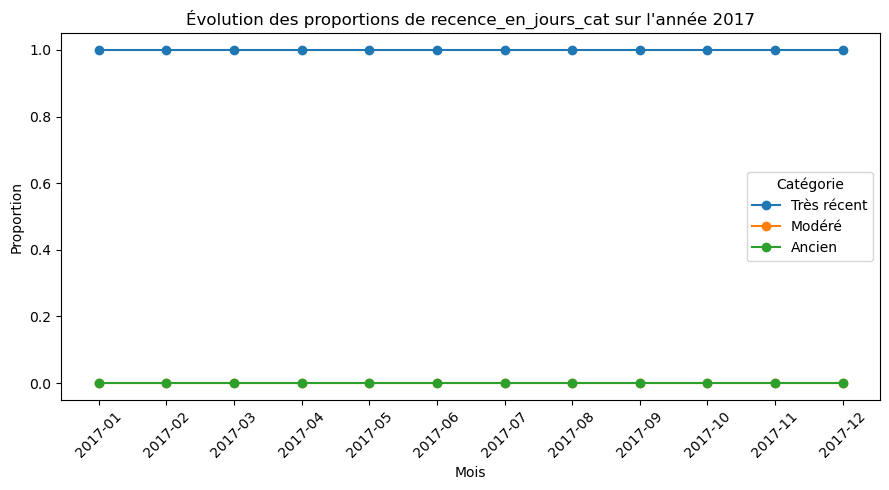

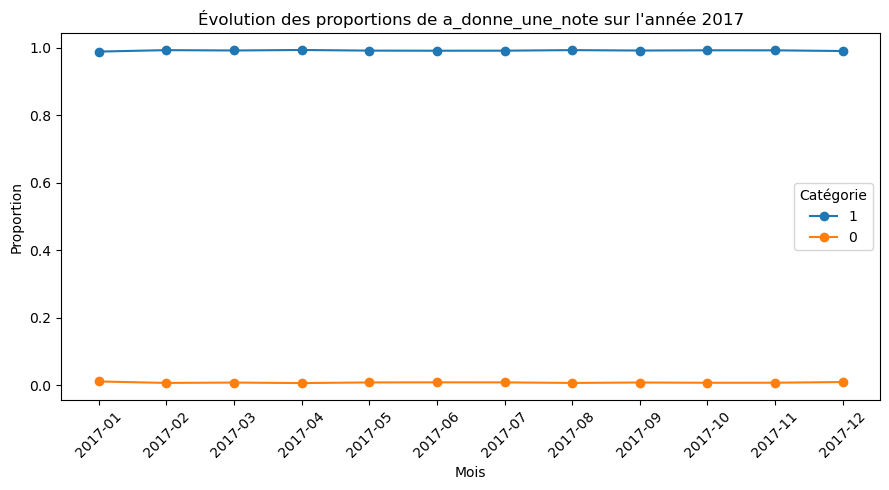

In [17]:
# Variables catégorielles à analyser
features_cat = ['recence_en_jours_cat', 'a_donne_une_note']

for feature in features_cat:
    # Calcul des proportions pour chaque modalité, chaque mois
    prop_cat = pd.DataFrame([
        dfs_mensuels_reduits[m][feature].value_counts(normalize=True)
        for m in mois
    ], index=mois).fillna(0)
    
    # Affichage
    plt.figure(figsize=(9, 5))
    for cat in prop_cat.columns:
        plt.plot(prop_cat.index, prop_cat[cat], marker='o', label=str(cat))
    plt.title(f"Évolution des proportions de {feature} sur l'année 2017")
    plt.xlabel("Mois")
    plt.ylabel("Proportion")
    plt.legend(title="Catégorie")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

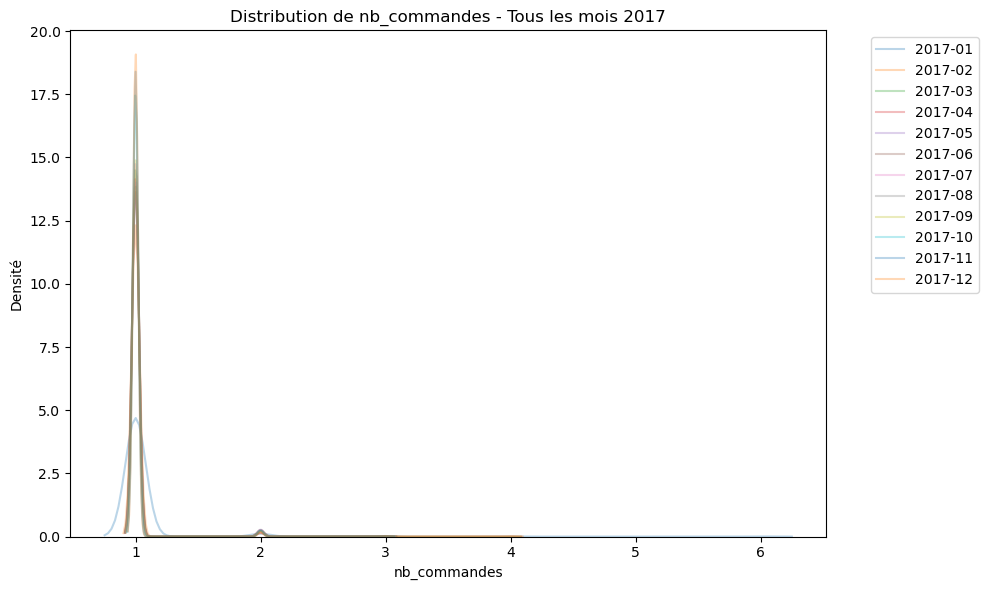

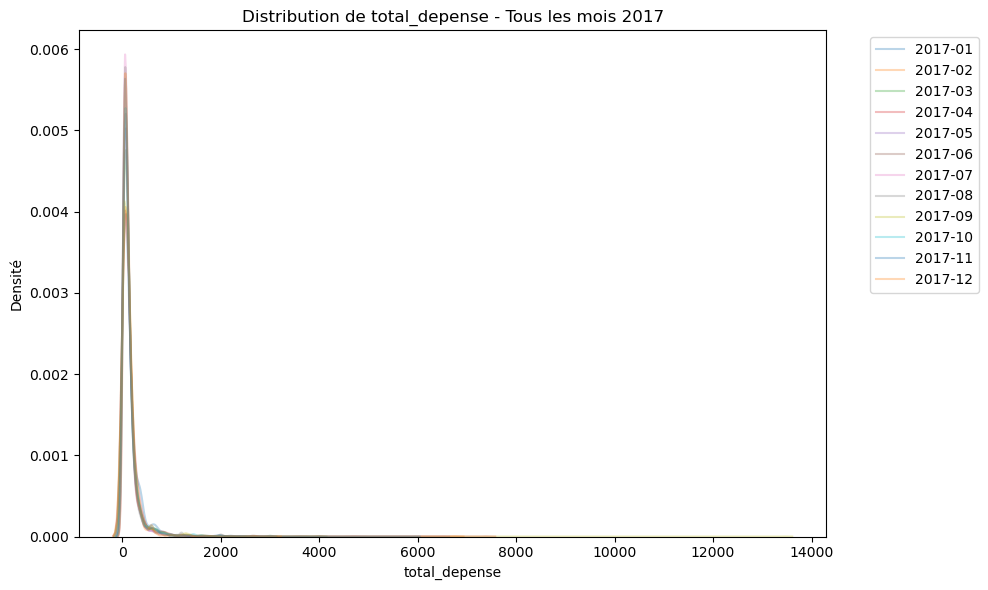

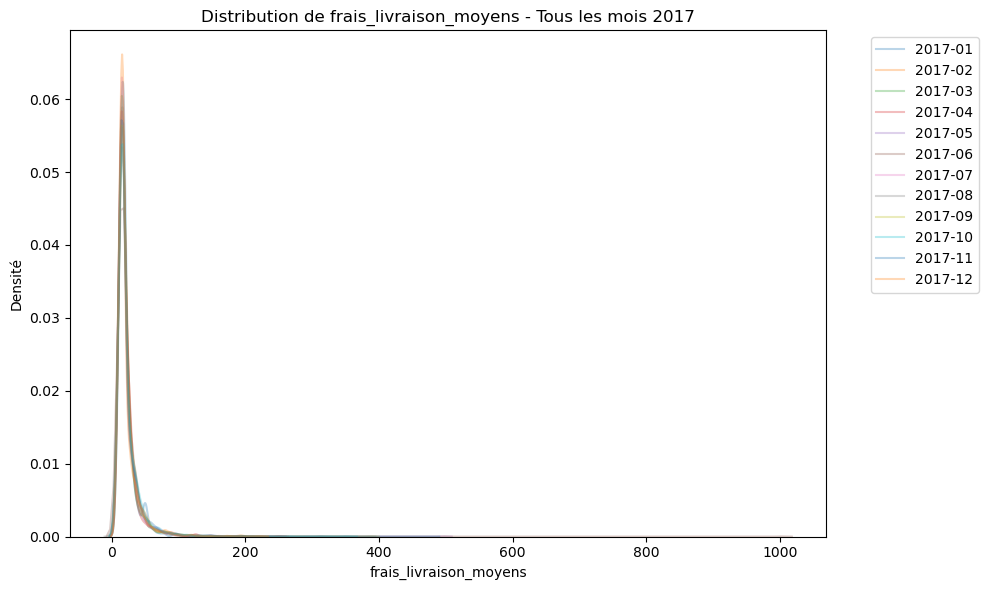

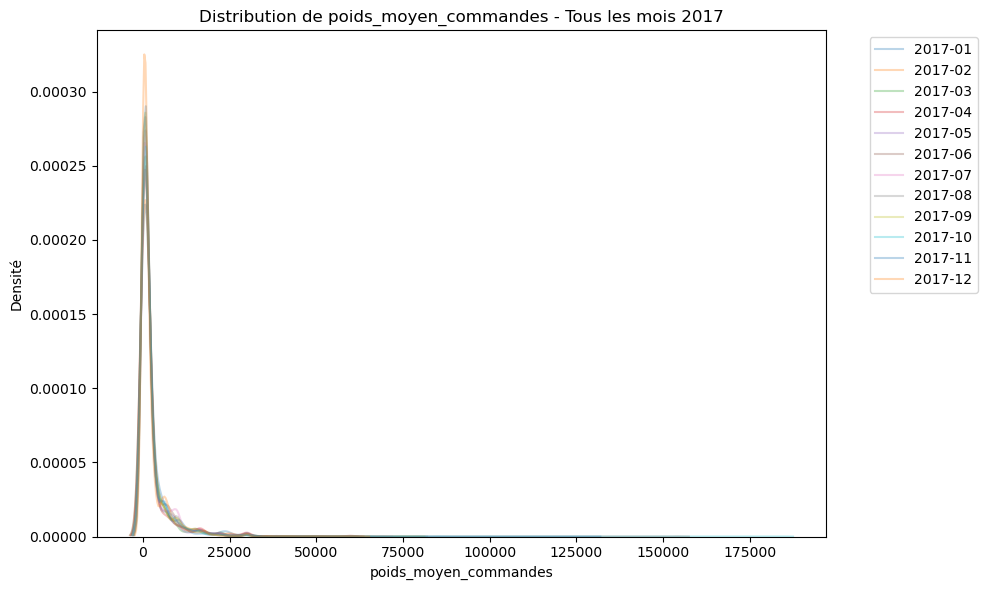

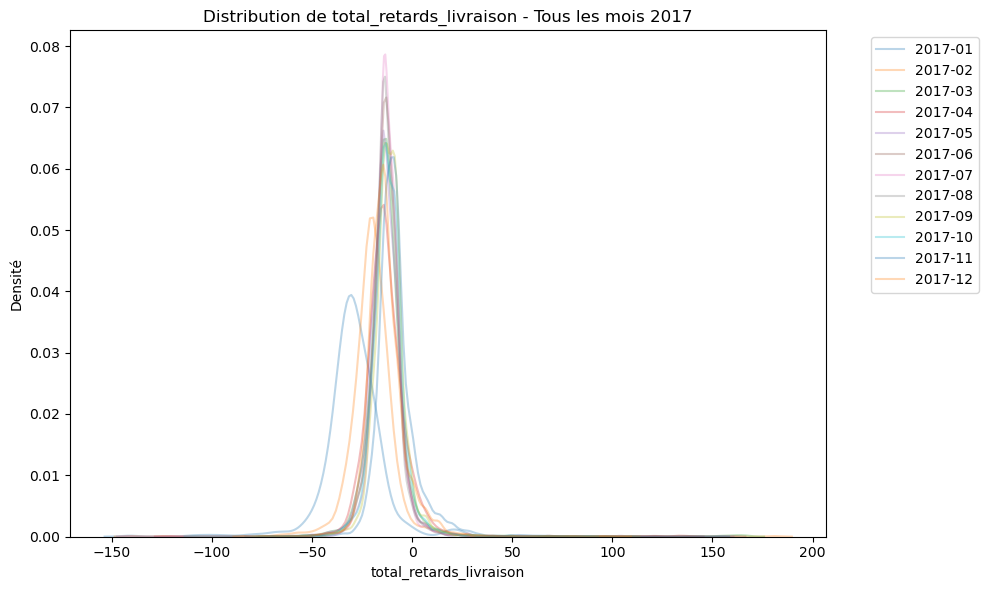

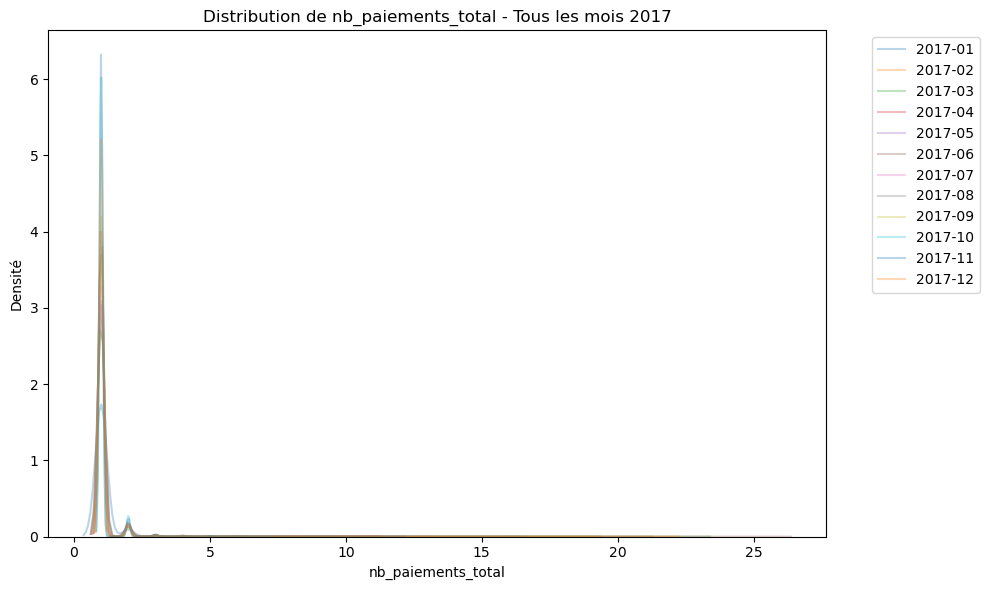

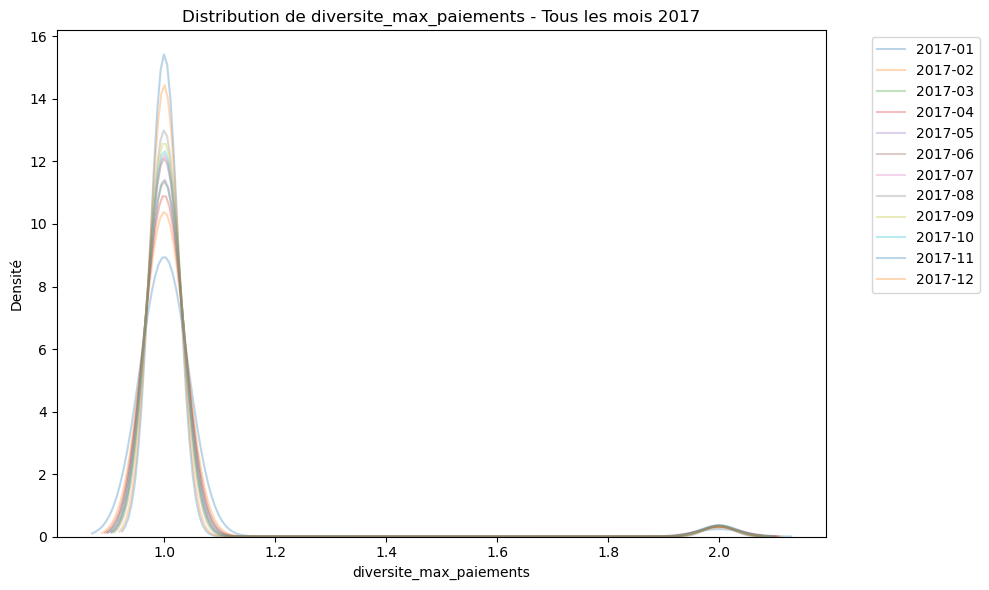

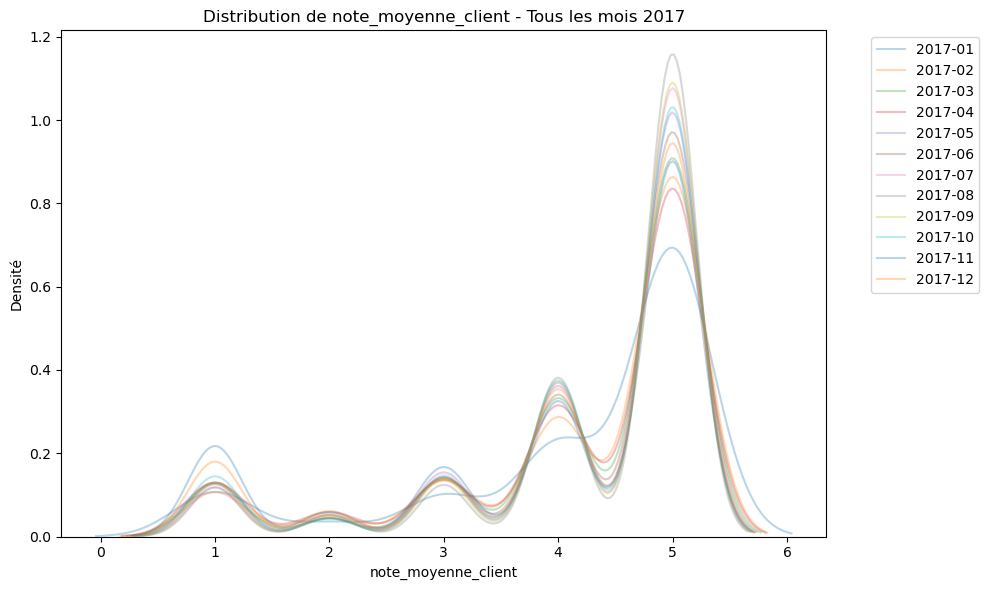

In [18]:
features_numeriques = [
    'nb_commandes', 'total_depense', 'frais_livraison_moyens',
    'poids_moyen_commandes', 'total_retards_livraison',
    'nb_paiements_total', 'diversite_max_paiements', 'note_moyenne_client'
]

for feature in features_numeriques:
    plt.figure(figsize=(10, 6))
    for m in mois:
        sns.kdeplot(dfs_mensuels_reduits[m][feature], label=m, alpha=0.3)
    plt.title(f"Distribution de {feature} - Tous les mois 2017")
    plt.xlabel(feature)
    plt.ylabel("Densité")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [19]:
ks_results = {}
seuil_p = 0.05  # Seuil de significativité classique

for feature in features_numeriques:
    ks_results[feature] = {}
    data_ref = dfs_mensuels_reduits['2017-01'][feature].dropna()  # Mois de référence
    print(f"\nK-S test pour {feature} (vs janvier) :")
    for m in mois:
        if m == '2017-01':
            continue  # On ne compare pas janvier à lui-même
        data_mois = dfs_mensuels_reduits[m][feature].dropna()
        ks_stat, ks_p = ks_2samp(data_ref, data_mois)
        ks_results[feature][m] = {'statistic': ks_stat, 'p_value': ks_p}
        # Détermination de la significativité basée uniquement sur la p-value
        significatif = ks_p < seuil_p
        msg = "SIGNIFICATIF" if significatif else "non significatif"
        print(f"{m} : statistic={ks_stat:.3f}, p-value={ks_p:.3f} --> {msg}")


K-S test pour nb_commandes (vs janvier) :
2017-02 : statistic=0.018, p-value=0.998 --> non significatif
2017-03 : statistic=0.015, p-value=1.000 --> non significatif
2017-04 : statistic=0.019, p-value=0.993 --> non significatif
2017-05 : statistic=0.011, p-value=1.000 --> non significatif
2017-06 : statistic=0.011, p-value=1.000 --> non significatif
2017-07 : statistic=0.013, p-value=1.000 --> non significatif
2017-08 : statistic=0.013, p-value=1.000 --> non significatif
2017-09 : statistic=0.015, p-value=1.000 --> non significatif
2017-10 : statistic=0.017, p-value=0.996 --> non significatif
2017-11 : statistic=0.017, p-value=0.995 --> non significatif
2017-12 : statistic=0.019, p-value=0.976 --> non significatif

K-S test pour total_depense (vs janvier) :
2017-02 : statistic=0.066, p-value=0.035 --> SIGNIFICATIF
2017-03 : statistic=0.061, p-value=0.039 --> SIGNIFICATIF
2017-04 : statistic=0.049, p-value=0.162 --> non significatif
2017-05 : statistic=0.069, p-value=0.010 --> SIGNIFIC

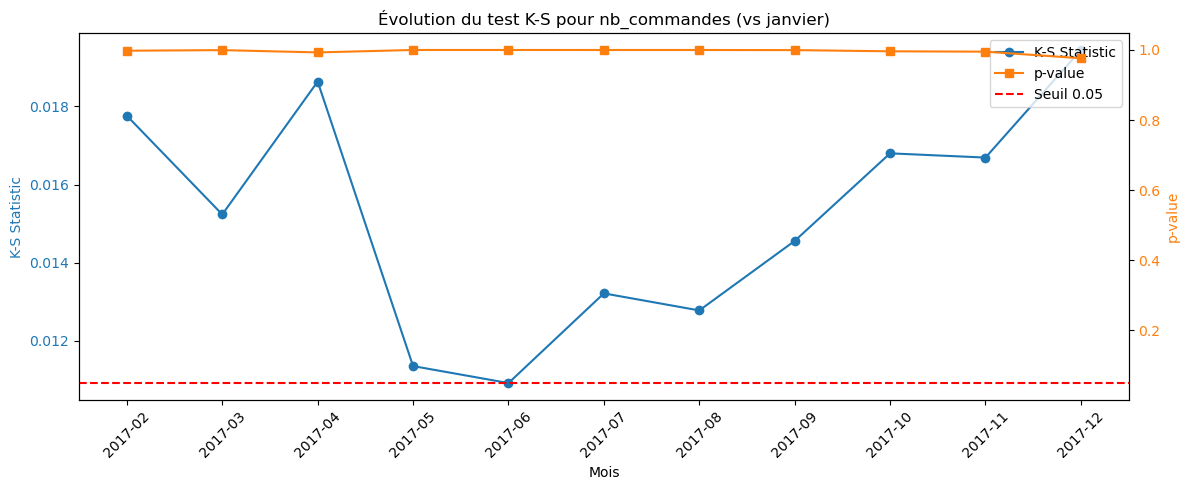

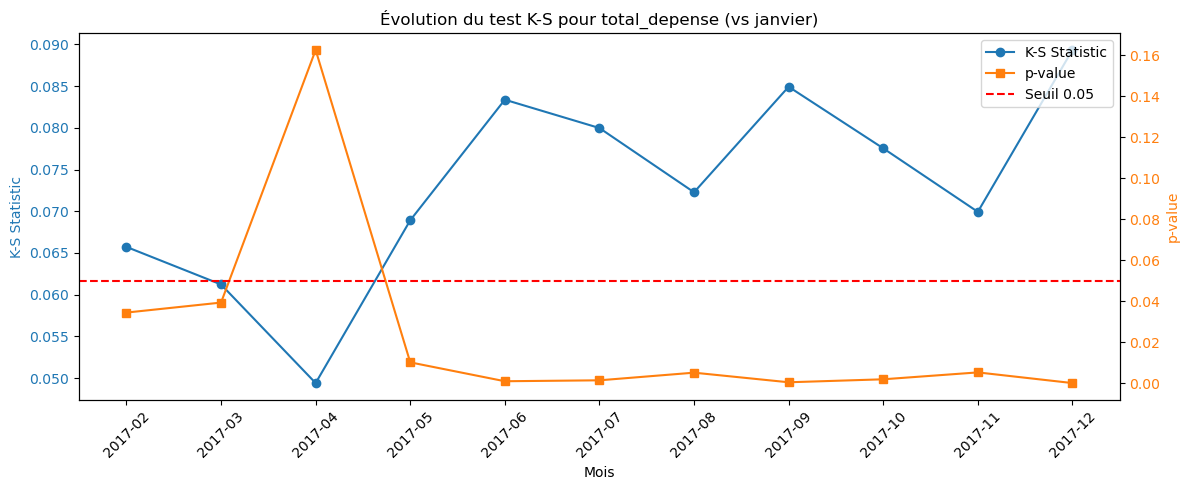

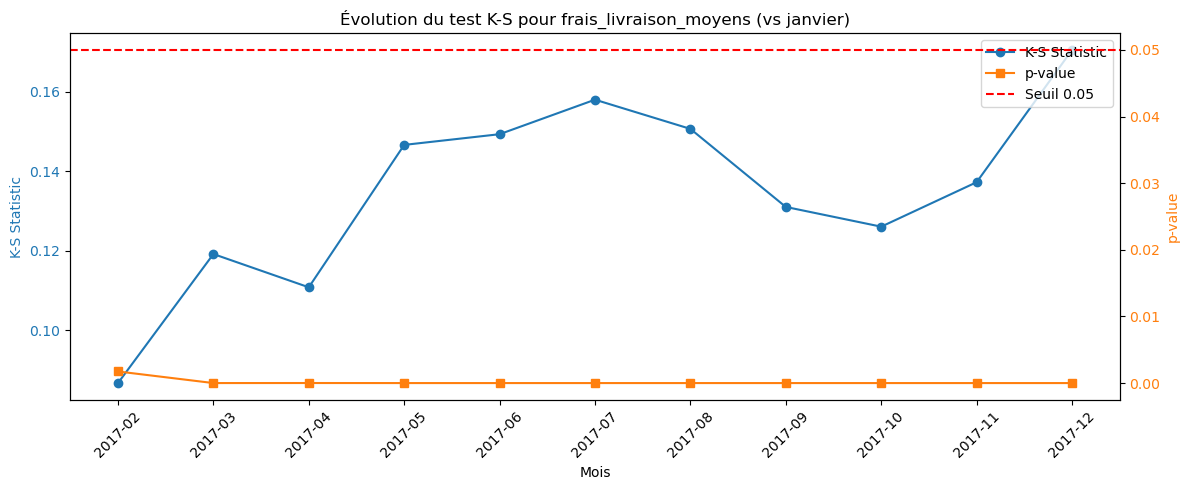

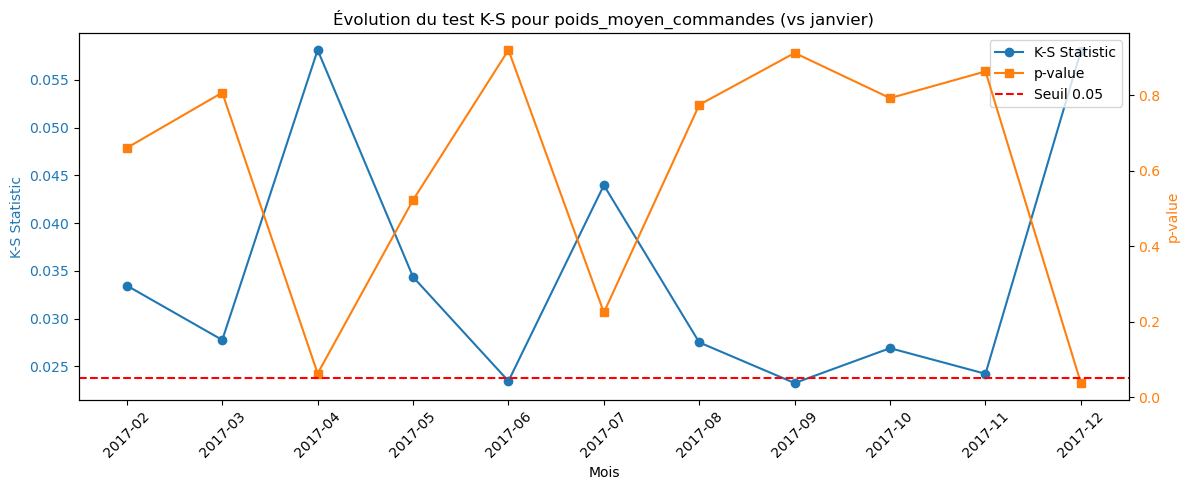

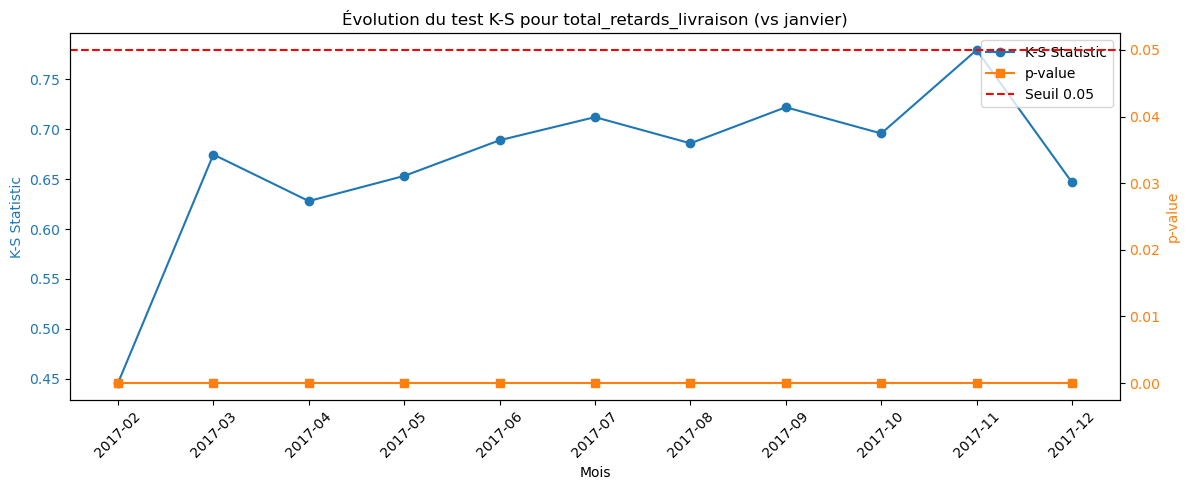

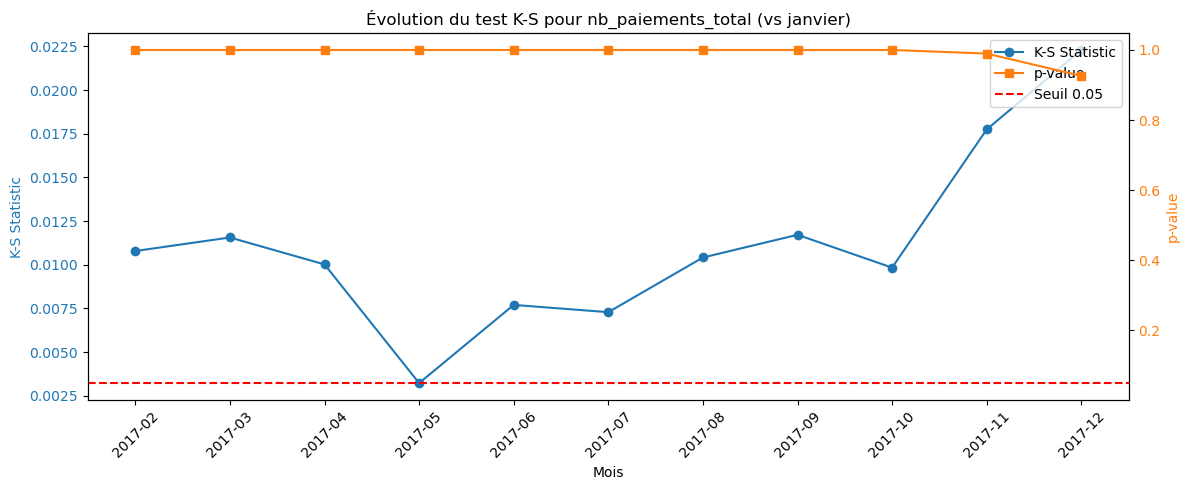

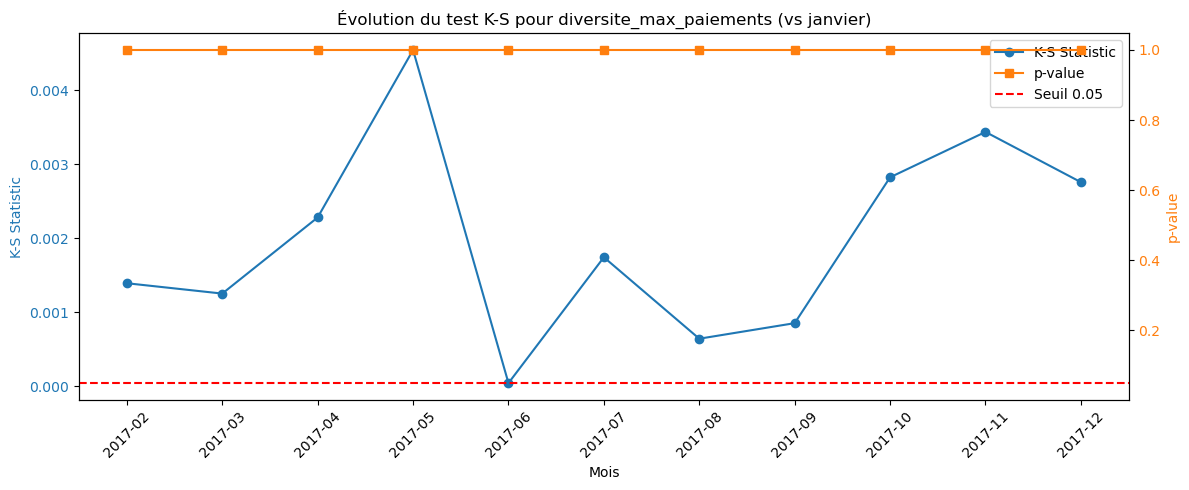

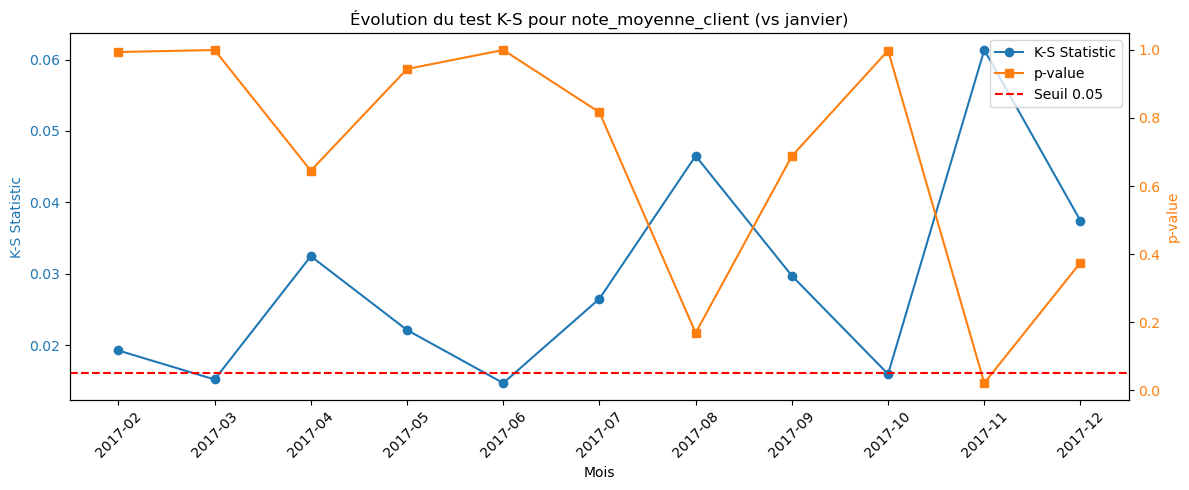

In [20]:
for feature in features_numeriques:
    ks_df = pd.DataFrame(ks_results[feature]).T

    # On crée une liste de positions pour chaque mois (abscisses des graphiques)
    positions = range(len(ks_df.index))

    fig, ax1 = plt.subplots(figsize=(12, 5))

    # --- Tracé de la statistique K-S (échelle de gauche) ---
    color = 'tab:blue'
    ax1.set_xlabel('Mois')
    ax1.set_ylabel('K-S Statistic', color=color)
    # On trace la statistique K-S pour chaque mois
    ax1.plot(positions, ks_df['statistic'], marker='o', color=color, label='K-S Statistic')
    ax1.tick_params(axis='y', labelcolor=color)
    # On fixe les positions et les labels des mois sur l'axe des x
    ax1.set_xticks(positions)
    ax1.set_xticklabels(ks_df.index, rotation=45)
    ax1.set_title(f"Évolution du test K-S pour {feature} (vs janvier)")

    # --- Tracé de la p-value (échelle de droite) ---
    ax2 = ax1.twinx()  # On crée un second axe y pour la p-value
    color = 'tab:orange'
    ax2.set_ylabel('p-value', color=color)
    # On trace la p-value pour chaque mois
    ax2.plot(positions, ks_df['p_value'], marker='s', color=color, label='p-value')
    # On ajoute une ligne horizontale pour le seuil de significativité (0.05)
    ax2.axhline(0.05, color='red', linestyle='--', label='Seuil 0.05')
    ax2.tick_params(axis='y', labelcolor=color)

    # --- Légende combinée des deux axes ---
    lines, labels = [], []
    for ax in [ax1, ax2]:
        line, label = ax.get_legend_handles_labels()
        lines += line
        labels += label
    ax1.legend(lines, labels, loc='upper right')

    plt.tight_layout()
    plt.show()

Conclusion sur l’évolution des distributions (test K-S)
Certaines variables présentent une forte stabilité tout au long de l’année 2017, comme :
- nb_commandes
- nb_paiements_total
- diversite_max_paiements
- note_moyenne_client (sauf novembre)

D’autres variables montrent des évolutions significatives (p-value < 0.05) sur plusieurs mois, notamment :
- total_depense
- frais_livraison_moyens
- total_retards_livraison

La variable poids_moyen_commandes est globalement stable, sauf en décembre où une différence significative apparaît.<br>
La variable note_moyenne_client n’est significativement différente qu’en novembre.

Concernant la récence, l’analyse graphique montre que la quasi-totalité des clients chaque mois sont classés comme “très récents”. Cela s’explique par notre méthodologie : **nous analysons uniquement les clients actifs du mois**, ce qui fait logiquement disparaître la diversité sur cette variable.<br>
Par conséquent, la récence n’est pas discriminante dans l’évolution des clusters mensuels, et la stabilité observée sur cette dimension est attendue.

Par ailleurs, l’analyse de la variance inter-cluster sur la base complète confirme que la récence, qu’elle soit ancienne ou très récente, n’apporte que **peu de différenciation entre les clusters**. Les variables les plus discriminantes sont “a_donné_une_note”, “diversité des catégories achetées”, ou “diversité des moyens de paiement”. Cela confirme que, dans notre contexte, la récence n’est pas une variable clé pour segmenter la clientèle, surtout parmi les clients actifs du mois.

Nous cherchons à analyser les changements de comportement chez les nouveaux clients actifs chaque mois. Dans ce cadre, l’absence de diversité dans la récence n’est pas un problème : notre analyse se concentre donc sur les autres dimensions comportementales (fréquence, montant, diversité, etc.) pour détecter les évolutions dans les profils clients.
Ainsi, la méthode permet de mesurer efficacement la stabilité de la segmentation et de déterminer la fréquence optimale de réentraînement du modèle.

La majorité des variables sont stables dans le temps, ce qui suggère une bonne robustesse de la segmentation sur ces axes.
Quelques variables (notamment liées aux dépenses et aux retards de livraison) évoluent significativement, ce qui pourrait indiquer des changements de comportement client ou de contexte logistique au fil de l’année.


# Évaluation de la stabilité des clusters et recommandation de la fréquence de mise à jour

Après avoir analysé l’évolution des distributions des variables individuelles, nous évaluons maintenant la stabilité globale de la segmentation à l’aide de l’Adjusted Rand Index (ARI). L’ARI permet de quantifier la similarité entre les segmentations obtenues à différents moments, ce qui nous aide à déterminer si les groupes de clients identifiés restent stables ou s’ils évoluent de manière significative au fil du temps.

Étape 1 : Réentraîner le modèle K-means sur les données mensuelles
- Objectif : Réentraîner le modèle K-means sur chaque DataFrame mensuel (dans dfs_mensuels_reduits) pour obtenir les labels de clusters propres à chaque période.
- Clustering de référence : Le modèle est entraîné sur le DataFrame du premier mois (par exemple, janvier 2017) pour obtenir une segmentation de référence.
- Clusterings successifs : Le modèle est ensuite réentraîné séparément sur chaque DataFrame mensuel suivant, afin de capturer l’évolution potentielle des groupes de clients au fil des mois.

Étape 2 : Calcul de l’Adjusted Rand Index (ARI)
- Pour chaque mois, nous comparons les labels de clusters obtenus à ceux du mois de référence à l’aide de l’ARI.
- L’ARI mesure la similarité entre deux segmentations :
- - Une valeur proche de 1 indique une forte stabilité des clusters (peu de changement dans la structure des groupes).
- - Une valeur proche de 0 indique une divergence importante, suggérant que la segmentation évolue significativement.


En combinant les résultats de l’analyse des distributions des variables et de l’ARI, nous pouvons formuler une recommandation robuste sur la fréquence de mise à jour du modèle de segmentation.
Si l’ARI reste élevé et que les distributions des variables sont stables, la segmentation peut être conservée sur plusieurs mois. À l’inverse, une baisse marquée de l’ARI ou des évolutions significatives dans les distributions indiqueront la nécessité de réentraîner le modèle plus fréquemment pour maintenir la pertinence des clusters.

Cette approche garantit une évaluation complète de la stabilité et de la robustesse de la segmentation clients dans le temps, en s’appuyant à la fois sur l’évolution des variables et sur la cohérence globale des clusters.

## Préprocessing

Dans cette section, nous appliquons un préprocessing strictement cohérent avec celui utilisé lors de l’entraînement initial du modèle K-means, afin d’assurer la comparabilité des segmentations mois par mois.
L’objectif est de garantir que toutes les transformations appliquées aux données mensuelles sont identiques à celles du jeu d’entraînement de référence.

Pourquoi cette cohérence est-elle essentielle ?
- Cohérence avec le modèle K-means :
Le modèle K-means est appliqué à chaque DataFrame mensuel après avoir standardisé les données avec le même StandardScaler (moyennes et écarts-types calculés sur les données d’entraînement de référence).
- Comparabilité temporelle :
En utilisant le scaler d’origine, chaque période mensuelle est transformée selon les mêmes critères, ce qui rend les clusters obtenus à différents moments directement comparables.
- Éviter les biais temporels :
Recalculer un scaler pour chaque mois introduirait des variations artificielles dans les échelles des features, ce qui pourrait fausser l’analyse de la stabilité des clusters.

**Étapes du préprocessing**<br>

Étape 1 : Encodage one-hot de la variable catégorielle<br>
Pour chaque DataFrame mensuel, nous appliquons un encodage one-hot sur la variable recence_en_jours_cat à l’aide de pd.get_dummies.<br>
Nous utilisons la structure obtenue sur le mois de janvier comme référence. Si une catégorie n’est pas présente dans un mois donné, la colonne correspondante est ajoutée avec des zéros, afin de garantir la cohérence des colonnes sur toute l’année.

Étape 2 : Réorganisation des colonnes<br>
Nous réorganisons les colonnes de chaque DataFrame mensuel pour qu’elles correspondent exactement à l’ordre et à la structure du DataFrame de janvier 2017.<br>
Cela garantit que toutes les périodes mensuelles sont alignées et prêtes à être standardisées de façon identique.

Étape 3 : Standardisation des données<br>
Nous ajustons le StandardScaler uniquement sur les données de janvier 2017 (notre période de référence).<br>
Ce scaler ainsi entraîné est ensuite utilisé tel quel pour transformer les données de tous les autres mois, sans être réajusté.
Cette méthode garantit que toutes les périodes mensuelles sont standardisées selon les mêmes moyennes et écarts-types, assurant la cohérence et la comparabilité des données dans le temps.

En suivant ces étapes, nous assurons une transformation homogène et fiable des données, condition indispensable pour évaluer la stabilité des clusters et la pertinence de la segmentation au fil du temps.

In [21]:
# 1. Définir les colonnes numériques et catégorielles
features_numeriques = [
    'nb_commandes', 'total_depense', 'frais_livraison_moyens',
    'poids_moyen_commandes', 'diversite_categories', 'total_retards_livraison',
    'nb_paiements_total', 'diversite_max_paiements', 'note_moyenne_client',
    'a_donne_une_note'
]
# Variables catégorielles à encoder
features_cat = ['recence_en_jours_cat']

# 2. Encodage one-hot sur janvier pour obtenir la structure de référence
df_janv = dfs_mensuels_reduits['2017-01'].copy()
df_janv_encoded = pd.get_dummies(df_janv, columns=features_cat)

# 3. Garder l’ordre des colonnes de référence
colonnes_ref = df_janv_encoded.columns

# 4. Ajuster le scaler sur janvier (seulement sur les colonnes numériques + one-hot)
scaler = StandardScaler()
X_janv = df_janv_encoded.values
scaler.fit(X_janv)  # On fit sur janvier UNIQUEMENT

# 5. Appliquer le même préprocessing à tous les mois
dfs_mensuels_preprocessed = {}

for m in mois:
    df = dfs_mensuels_reduits[m].copy()
    # Encodage one-hot
    df_encoded = pd.get_dummies(df, columns=features_cat)
    # Ajouter les colonnes manquantes (s'il manque une catégorie ce mois-là)
    for col in colonnes_ref:
        if col not in df_encoded.columns:
            df_encoded[col] = 0
    # Réorganiser les colonnes dans le même ordre que janvier
    df_encoded = df_encoded[colonnes_ref]
    # Standardisation avec le scaler "fit" sur janvier
    X_scaled = scaler.transform(df_encoded.values)
    df_scaled = pd.DataFrame(X_scaled, columns=colonnes_ref, index=df_encoded.index)
    # Stocker le DataFrame prétraité
    dfs_mensuels_preprocessed[m] = df_scaled

In [22]:
# On prend la structure de référence (colonnes de janvier)
colonnes_ref = dfs_mensuels_preprocessed['2017-01'].columns

# On vérifie chaque DataFrame mensuel
for m in mois:
    df = dfs_mensuels_preprocessed[m]
    # Vérification du nombre de colonnes
    nb_colonnes_ok = len(df.columns) == len(colonnes_ref)
    # Vérification de l'ordre et du nom des colonnes
    colonnes_ok = all(df.columns == colonnes_ref)
    # Affichage du résultat
    print(f"{m} : nb_colonnes_ok = {nb_colonnes_ok}, colonnes_ok = {colonnes_ok}")
    if not nb_colonnes_ok or not colonnes_ok:
        print(" Problème détecté dans ce DataFrame !")

2017-01 : nb_colonnes_ok = True, colonnes_ok = True
2017-02 : nb_colonnes_ok = True, colonnes_ok = True
2017-03 : nb_colonnes_ok = True, colonnes_ok = True
2017-04 : nb_colonnes_ok = True, colonnes_ok = True
2017-05 : nb_colonnes_ok = True, colonnes_ok = True
2017-06 : nb_colonnes_ok = True, colonnes_ok = True
2017-07 : nb_colonnes_ok = True, colonnes_ok = True
2017-08 : nb_colonnes_ok = True, colonnes_ok = True
2017-09 : nb_colonnes_ok = True, colonnes_ok = True
2017-10 : nb_colonnes_ok = True, colonnes_ok = True
2017-11 : nb_colonnes_ok = True, colonnes_ok = True
2017-12 : nb_colonnes_ok = True, colonnes_ok = True


## Application du modèle K-means et évaluation de la stabilité temporelle des clusters avec l’ARI

Dans cette section, nous évaluons la stabilité de la segmentation K-means au fil du temps en comparant, pour chaque période, deux segmentations :
- La segmentation obtenue en ré-entraînant K-means sur les données du mois courant (K-means "réadapté").
- La segmentation obtenue en appliquant le modèle K-means entraîné sur janvier (K-means "fixe") sur les données du mois courant.

Cette approche permet de mesurer, via l’Adjusted Rand Index (ARI), à quel point la structure des clusters change au fil du temps, et ainsi de déterminer à quel moment il devient pertinent de réentraîner le modèle sur les nouvelles données.

**Démarche détaillée**

- Entraînement initial (janvier 2017)
On entraîne un modèle K-means de référence (K-means 0) sur les données prétraitées de janvier 2017.

- Pour chaque mois suivant (février, mars, avril, etc.)

- - On entraîne un nouveau modèle K-means sur les données du mois courant (K-means t).
- - On applique également le modèle K-means 0 (entraîné sur janvier) pour prédire les clusters sur les données du mois courant.
- - On compare les labels de clusters obtenus par le K-means réentraîné (K-means t) et par le K-means de janvier (K-means 0) à l’aide de l’Adjusted Rand Index (ARI).

**Interprétation de l’ARI**

- Un ARI proche de 1 indique que la structure des clusters reste très stable : le modèle de janvier reste pertinent.
- Un ARI qui diminue indique que la structure des groupes évolue : il devient alors pertinent de réentraîner le modèle sur les données récentes.

**Avantages de cette approche**

- Détection précise des ruptures : On sait exactement à quel moment la segmentation issue du modèle initial devient obsolète.
- Décision objective sur la fréquence de réentraînement : L’ARI sert de critère quantitatif pour décider quand mettre à jour le modèle.
- Comparaison directe entre modèle fixe et modèle réadapté.

**En résumé :**
À chaque nouvelle période, on compare la segmentation obtenue par un modèle réentraîné sur les données actuelles à celle prédite par le modèle initial de janvier. L’ARI mesure la divergence entre ces deux segmentations, permettant de piloter objectivement la fréquence de réentraînement du modèle K-means.

C:\Users\joan6\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\joan6\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


2017-01 : ARI = 1.000
2017-02 : ARI = 0.711
2017-03 : ARI = 0.918
2017-04 : ARI = 0.960
2017-05 : ARI = 0.645
2017-06 : ARI = 0.887
2017-07 : ARI = 0.589
2017-08 : ARI = 0.727
2017-09 : ARI = 0.628
2017-10 : ARI = 0.741
2017-11 : ARI = 0.524
2017-12 : ARI = 0.406


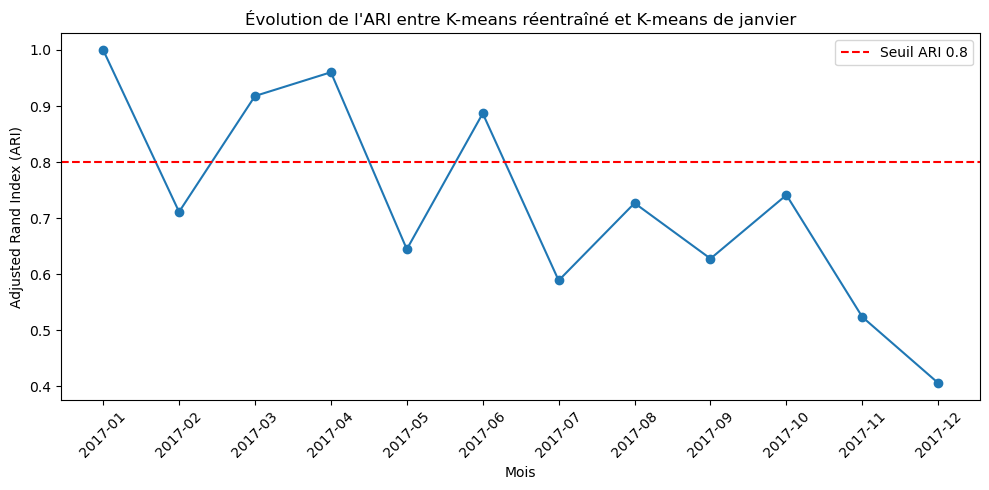

In [23]:
# Paramètres
n_clusters = 8 

# 1. Entraînement du K-means de référence sur janvier
X_janv = dfs_mensuels_preprocessed['2017-01'].values
kmeans_0 = KMeans(n_clusters=n_clusters, random_state=42)
labels_janv_kmeans0 = kmeans_0.fit_predict(X_janv)

# Dictionnaires pour stocker les résultats
labels_kmeans = {'2017-01': labels_janv_kmeans0}
labels_kmeans0_predict = {'2017-01': labels_janv_kmeans0}
ari_scores = {}

# Calcul de l'ARI pour janvier (doit être 1)
ari_janv = adjusted_rand_score(labels_janv_kmeans0, labels_janv_kmeans0)
ari_scores['2017-01'] = ari_janv
print(f"2017-01 : ARI = {ari_janv:.3f}")

# 2. Pour chaque mois suivant, entraîner un nouveau K-means et comparer aux prédictions du modèle de janvier
for m in mois:
    if m == '2017-01':
        continue
    X_mois = dfs_mensuels_preprocessed[m].values

    # Réentraînement du K-means sur le mois courant
    kmeans_t = KMeans(n_clusters=n_clusters, random_state=42)
    labels_kmeans_t = kmeans_t.fit_predict(X_mois)
    labels_kmeans[m] = labels_kmeans_t

    # Prédiction des clusters avec le modèle de janvier (K-means 0)
    labels_kmeans0_pred = kmeans_0.predict(X_mois)
    labels_kmeans0_predict[m] = labels_kmeans0_pred

    # Calcul de l'ARI entre les deux segmentations
    ari = adjusted_rand_score(labels_kmeans_t, labels_kmeans0_pred)
    ari_scores[m] = ari
    print(f"{m} : ARI = {ari:.3f}")

# Visualisation de l'évolution de l'ARI dans le temps
mois_plot = [m for m in mois]  # Inclut janvier
ari_values = [ari_scores[m] for m in mois_plot]

plt.figure(figsize=(10, 5))
plt.plot(mois_plot, ari_values, marker='o')
plt.axhline(0.8, color='red', linestyle='--', label='Seuil ARI 0.8')
plt.title("Évolution de l'ARI entre K-means réentraîné et K-means de janvier")
plt.xlabel("Mois")
plt.ylabel("Adjusted Rand Index (ARI)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Conclusion sur la fréquence de mise à jour de la segmentation

Notre analyse de la stabilité de la segmentation K-means, mesurée par l’Adjusted Rand Index (ARI), montre que la structure des groupes clients évolue très rapidement dans notre base. En effet, l’ARI chute sous le seuil de 0,8 dès le deuxième mois, ce qui indique que la segmentation réalisée en janvier n’est déjà plus adaptée en février.

Cette forte variabilité s’explique principalement par le fait que la majorité de nos clients ne commandent qu’une seule fois : la population de clients se renouvelle donc presque entièrement chaque mois. Dans ce contexte, il n’existe pas de stabilité dans les comportements individuels ; ce sont de nouveaux profils qui apparaissent en permanence, modifiant la structure globale des groupes.

C’est pourquoi nous avons choisi d’évaluer la pertinence de la segmentation mois par mois, plutôt que de cumuler les données sur plusieurs mois. Cumuler les données reviendrait à mélanger des comportements anciens et récents, ce qui “diluerait” l’impact des nouveaux clients et masquerait les évolutions réelles de la clientèle. En procédant par analyse mensuelle, nous pouvons détecter immédiatement les changements dans la structure des clients et adapter la segmentation en temps réel.

Recommandation :<br>
Nous recommandons donc de mettre à jour la segmentation chaque mois afin de garantir que les clusters restent pertinents et reflètent fidèlement la réalité des comportements clients. Cette fréquence mensuelle est la seule qui permette de maintenir la valeur opérationnelle de la segmentation dans un contexte aussi dynamique et mouvant.

# Stratégie d'ajout d'un nouveau client

Pour intégrer un nouveau client dans le processus de clustering, il est nécessaire de suivre ces étapes :

1. Collecte des données : récupérer les informations sur le client depuis `orders`, `payments`, etc., et consolider ces données.
2. Gestion des données manquantes : traiter les valeurs manquantes manuellement ou via une règle systématique si possible.
3. Prétraitement : appliquer les mêmes transformations que celles utilisées lors de l'entraînement (encodage, standardisation).
4. Prédiction : utiliser le modèle K-means préentraîné pour attribuer un cluster au client.
5. Mise à jour : si nécessaire, relancer certaines analyses pour inclure ce client dans les statistiques globales.

**Limitations actuelles**

Actuellement, l'ajout d'un nouveau client nécessite une intervention manuelle pour gérer certaines étapes comme la fusion des DataFrames et la gestion des valeurs manquantes. Cela rend le processus moins adapté à une automatisation immédiate.

**Proposition pour une automatisation future**

Pour simplifier ce processus à l'avenir, il serait pertinent de :
1. Définir des règles systématiques pour traiter les données manquantes.
2. Créer une fonction regroupant toutes les étapes nécessaires (fusion, transformation et prédiction).
3. Intégrer cette fonction dans un workflow automatisé (par exemple via une API).

Bien que cette vision ne soit pas implémentée dans ce projet, elle constitue une piste d'amélioration importante pour rendre le processus plus efficace et scalable.